In [ ]:
!pip install captcha
!pip install Pillow
!pip install seaborn

!git clone https://github.com/JackonYang/captcha-tensorflow.git

     |████████████████████████████████| 101 kB 2.8 MB/s 
Cloning into 'captcha-tensorflow'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 406 (delta 30), reused 43 (delta 17), pack-reused 337
Receiving objects: 100% (406/406), 4.99 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (199/199), done.


In [ ]:
# !python captcha-tensorflow/datasets/gen_captcha.py -du --npi=6 -n 1

!python3 captcha-tensorflow/datasets/gen_captcha.py -d --npi 4 -n 7

10 choices: 0123456789
generating 7 epoches of captchas in ./images/char-4-epoch-7/train.
(1/7) epoches finished
(2/7) epoches finished
(3/7) epoches finished
(4/7) epoches finished
(5/7) epoches finished
(6/7) epoches finished
(7/7) epoches finished
write meta info in ./images/char-4-epoch-7/meta.json


# New Section

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import os
import time
import json
import glob

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

tf.__version__

DATA_DIR = './images/char-4-epoch-7/train'
H, W, C = 100, 240, 3  # height, width, 3(RGB channels)
N_LABELS = 256
D = 4 # num_per_image

In [ ]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [ ]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.png"))
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.head()

,label,file
0,8340,./images/char-4-epoch-7/train/8340_c8d8b2d2-6c...
1,2917,./images/char-4-epoch-7/train/2917_f4a12c68-cf...
2,5803,./images/char-4-epoch-7/train/5803_75ca3a3c-15...
3,4532,./images/char-4-epoch-7/train/4532_21e7d6ec-01...
4,8420,./images/char-4-epoch-7/train/8420_a85a2848-7a...


In [ ]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.8)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.8)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

train count: 22579, valid count: 5645, test count: 7056


In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              # optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 240, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 98, 238, 32)       896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 49, 119, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 47, 117, 64)       18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 23, 58, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 56, 64)        3692

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

# TODO: Changed epoch (from 7-->1) for code testing -- faster convergence.
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

model.save("./model_saved")

Epoch 1/5
352/352 [==============================] - 944s 3s/step - loss: 2.3067 - accuracy: 0.1311 - val_loss: 1.8282 - val_accuracy: 0.3385
Epoch 2/5
352/352 [==============================] - 931s 3s/step - loss: 1.2293 - accuracy: 0.5679 - val_loss: 0.7631 - val_accuracy: 0.7472
Epoch 3/5
352/352 [==============================] - 940s 3s/step - loss: 0.4930 - accuracy: 0.8380 - val_loss: 0.4435 - val_accuracy: 0.8586
Epoch 4/5
352/352 [==============================] - 935s 3s/step - loss: 0.2172 - accuracy: 0.9307 - val_loss: 0.3841 - val_accuracy: 0.8800
Epoch 5/5
352/352 [==============================] - 944s 3s/step - loss: 0.1145 - accuracy: 0.9638 - val_loss: 0.3641 - val_accuracy: 0.8965
INFO:tensorflow:Assets written to: ./model_saved/assets


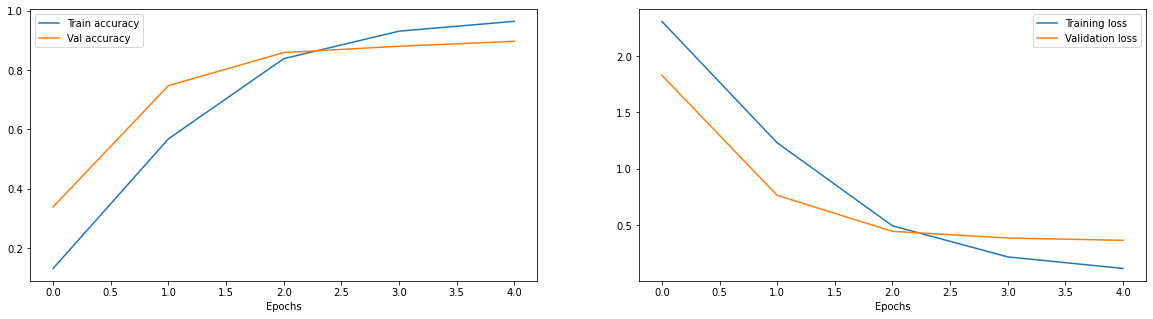

In [ ]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)
plt.show()

In [ ]:
from tensorflow import keras
model2 = keras.models.load_model('./model_saved')

# evaluate loss and accuracy in test dataset
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model2.metrics_names, model2.evaluate(test_gen, steps=len(test_idx)//128)))

55/55 [==============================] - 83s 1s/step - loss: 0.3670 - accuracy: 0.8958


{'accuracy': 0.8958096504211426, 'loss': 0.36704087257385254}

pred: 0576
pred: 2432
pred: 1436
pred: 5203
pred: 5209
pred: 2367
pred: 0482
pred: 3708
pred: 0042
pred: 8762
pred: 0721
pred: 0428
pred: 6053
pred: 6210
pred: 4518
pred: 0918
pred: 8526
pred: 6128
pred: 1984
pred: 1088
pred: 5674
pred: 3087
pred: 4039
pred: 0725
pred: 0839
pred: 6355
pred: 6743
pred: 1253
pred: 4553
pred: 5208
pred: 9213
pred: 3774
pred: 7459
pred: 5462
pred: 1540
pred: 5819
pred: 1645
pred: 6692
pred: 9231
pred: 9237
pred: 3697
pred: 7691
pred: 2467
pred: 5916
pred: 2773
pred: 2659
pred: 5408
pred: 2936
pred: 7048
pred: 8511
pred: 1324
pred: 0254
pred: 6593
pred: 0534
pred: 8570
pred: 6315
pred: 9173
pred: 6284
pred: 4709
pred: 0976
pred: 4582
pred: 4836
pred: 6395
pred: 0274
pred: 7605
pred: 3706
pred: 4319
pred: 5287
pred: 0396
pred: 2638
pred: 8230
pred: 7483
pred: 2637
pred: 1209
pred: 7025
pred: 2637
pred: 0519
pred: 8504
pred: 6405
pred: 2793
pred: 7159
pred: 1884
pred: 6447
pred: 9634
pred: 8149
pred: 3719
pred: 9658
pred: 1706
pred: 3647
pred: 7943
pred: 5948

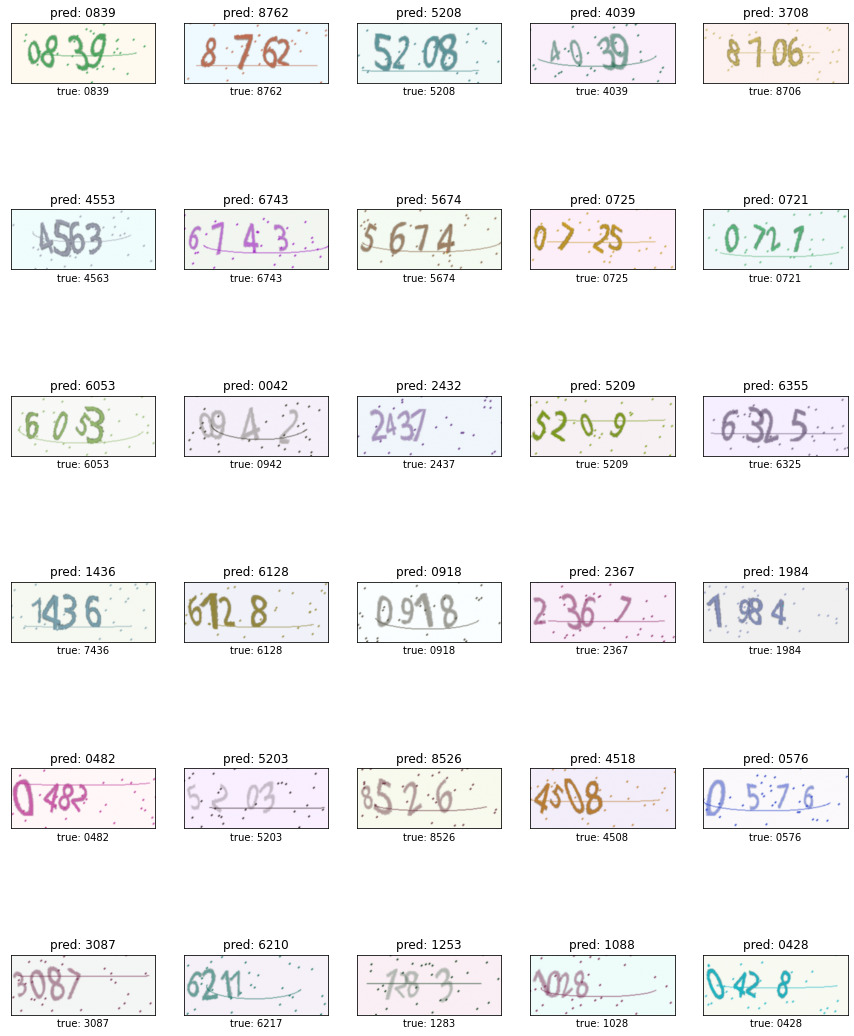

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)
# print(test_gen)
# print("****")
# print(x_test)
# print("****")
# print(y_test)
y_pred = model.predict_on_batch(x_test)
y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)
# print(y_pred)

def format_y(y):
    return ''.join(map(lambda x: chr(int(x)), y))

for pred in range(len(y_pred)):
  print('pred: %s' % format_y(y_pred[pred]))

import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: %s' % format_y(y_pred[img_idx]))
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
##Following codes are for mixed image testing

!unzip "/content/merged_imgs.zip" -d "/content/mixed_images/"

In [ ]:
##Following codes are for mixed image testing

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
import os
import time
import json
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

def parse_filepath_mixed(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label = filename
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

DATA_DIR_MIXED = '/content/mixed_images/merged_imgs/'
H, W, C = 100, 240, 3  # height, width, 3(RGB channels)
N_LABELS = 256
D = 4 # num_per_image

files_mixed = glob.glob(os.path.join(DATA_DIR_MIXED, "*.png"))
attributes_mixed = list(map(parse_filepath_mixed, files_mixed))

df_mixed = pd.DataFrame(attributes_mixed)
df_mixed['file'] = files_mixed
df_mixed.columns = ['label', 'file']
df_mixed = df_mixed.dropna()
print(df_mixed.head())

p = np.random.permutation(len(df_mixed))
test_idx_mixed = p[0:]
print(test_idx_mixed)
# p = np.random.permutation(len(df))
# train_up_to = 0
# train_idx = p[:train_up_to]
# test_idx = p[train_up_to:]

# train_up_to = 0
# train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('test count: %s' % (len(test_idx_mixed)))

def get_data_generator_mixed(df, indices, for_training, batch_size):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

model_saved = keras.models.load_model('./model_saved')
test_gen_mixed = get_data_generator_mixed(df_mixed, test_idx_mixed, for_training=False, batch_size=128)
# print(test_gen)
dict(zip(model_saved.metrics_names, model_saved.evaluate(test_gen_mixed, steps=len(test_idx_mixed)/128)))


  label                                        file
0  2839  /content/mixed_images/merged_imgs/2839.png
1  3766  /content/mixed_images/merged_imgs/3766.png
2  1653  /content/mixed_images/merged_imgs/1653.png
3  9537  /content/mixed_images/merged_imgs/9537.png
4  1906  /content/mixed_images/merged_imgs/1906.png
[1313 1183  236 ... 1095  635 1188]
test count: 1400
21/21 [==============================] - 17s 752ms/step - loss: 4.4912 - accuracy: 0.4935


{'accuracy': 0.4934895932674408, 'loss': 4.491222381591797}

pred: 8561
pred: 3779
pred: 4356
pred: 9546
pred: 7113
pred: 8319
pred: 2278
pred: 3663
pred: 7622
pred: 8579
pred: 7310
pred: 3410
pred: 1224
pred: 1356
pred: 7041
pred: 7741
pred: 8815
pred: 1667
pred: 5738
pred: 7663
pred: 3541
pred: 9817
pred: 7501
pred: 5519
pred: 9721
pred: 0811
pred: 1348
pred: 8359
pred: 8029
pred: 9658
pred: 9072
pred: 6971
pred: 0773
pred: 5984
pred: 7851
pred: 2317
pred: 4609
pred: 5591
pred: 6055
pred: 4517
pred: 6008
pred: 7801
pred: 9211
pred: 2754
pred: 1340
pred: 1513
pred: 7819
pred: 9977
pred: 0052
pred: 7511
pred: 4778
pred: 0655
pred: 8717
pred: 0319
pred: 2311
pred: 4881
pred: 2331
pred: 3116
pred: 0715
pred: 2611
pred: 0716
pred: 1348
pred: 7350
pred: 0314
pred: 8663
pred: 2051
pred: 8501
pred: 1374
pred: 1783
pred: 0919
pred: 5447
pred: 0795
pred: 7559
pred: 8668
pred: 6378
pred: 5041
pred: 8634
pred: 1721
pred: 7553
pred: 1346
pred: 4340
pred: 8511
pred: 2483
pred: 0734
pred: 2581
pred: 7784
pred: 2877
pred: 2622
pred: 4819
pred: 9348
pred: 2723

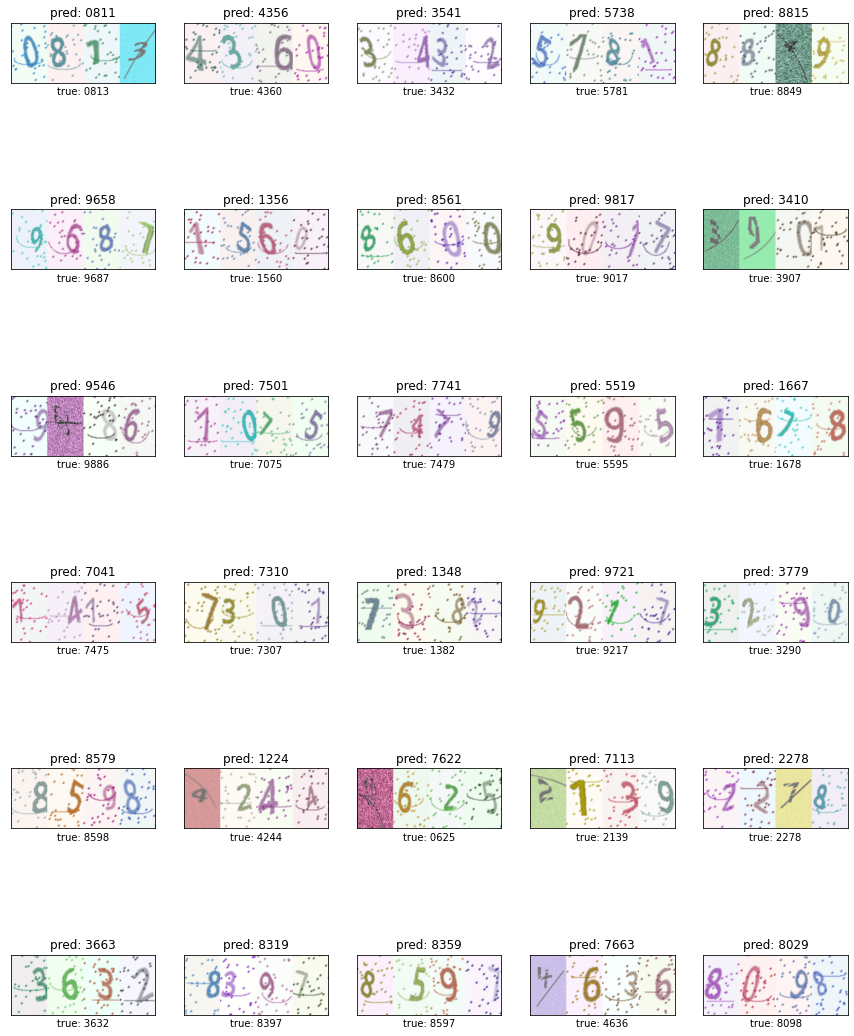

In [ ]:
test_gen_mix = get_data_generator_mixed(df_mixed, test_idx_mixed, for_training=False, batch_size=128)
x_test_mix, y_test_mix = next(test_gen_mix)
y_pred_mix = model.predict_on_batch(x_test_mix)
y_true_mix = tf.math.argmax(y_test_mix, axis=-1)
y_pred_mix = tf.math.argmax(y_pred_mix, axis=-1)
# print(y_pred)

def format_y(y):
    return ''.join(map(lambda x: chr(int(x)), y))

for pred in range(len(y_pred_mix)):
  print('pred: %s' % format_y(y_pred_mix[pred]))

import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test_mix[img_idx])
    ax.set_title('pred: %s' % format_y(y_pred_mix[img_idx]))
    ax.set_xlabel('true: %s' % format_y(y_true_mix[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()